<a href="https://colab.research.google.com/github/parmarsuraj99/Autoencoders/blob/master/DeepAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

In [0]:
from keras.datasets import mnist
from keras.layers import Input, Dense
from keras.models import Model

Using TensorFlow backend.


In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


In [0]:
x_train.shape

(60000, 28, 28)

In [0]:
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

Reshaping images, Flattening them to feed to a Dense network

we won't do this in ConvNets

In [0]:
x_train = x_train.reshape(len(x_train), (x_train.shape[1]*x_train.shape[2]))
x_test = x_test.reshape(len(x_test), (x_test.shape[1]*x_test.shape[2]))

In [0]:
encoding_dim = 32

input_img = Input(shape = (784, ))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(encoding_dim, activation='relu')(encoded)


decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)

In [0]:
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim, ))
decode_layer1 = autoencoder.layers[-2]
decode_layer2 = autoencoder.layers[-1]
decoder = Model(encoded_input, decode_layer2(decode_layer1(encoded_input)))

In [0]:
autoencoder.get_layer('dense_5')

In [0]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_6 (Dense)              (None, 784)               101136    
Total params: 209,968
Trainable params: 209,968
Non-trainable params: 0
_________________________________________________________________


In [0]:
hist = autoencoder.fit(x_train, x_train, epochs=10, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 12s 202us/step - loss: 0.2129 - acc: 0.7929 - val_loss: 0.1578 - val_acc: 0.8043
Epoch 2/10
60000/60000 [==============================] - 12s 196us/step - loss: 0.1422 - acc: 0.8077 - val_loss: 0.1278 - val_acc: 0.8080
Epoch 3/10
60000/60000 [==============================] - 12s 195us/step - loss: 0.1226 - acc: 0.8108 - val_loss: 0.1157 - val_acc: 0.8114
Epoch 4/10
60000/60000 [==============================] - 12s 195us/step - loss: 0.1142 - acc: 0.8118 - val_loss: 0.1086 - val_acc: 0.8115
Epoch 5/10
60000/60000 [==============================] - 12s 198us/step - loss: 0.1088 - acc: 0.8125 - val_loss: 0.1063 - val_acc: 0.8110
Epoch 6/10
60000/60000 [==============================] - 12s 196us/step - loss: 0.1050 - acc: 0.8129 - val_loss: 0.1020 - val_acc: 0.8117
Epoch 7/10
60000/60000 [==============================] - 12s 195us/step - loss: 0.1019 - acc: 0.8132 - val_loss: 0.

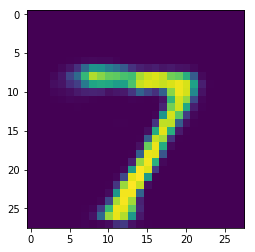

In [0]:
encoded_images = encoder.predict(x_test)
encoded_images.shape
predicted = decoder.predict(encoded_images)
plt.imshow(predicted[0].reshape(28, 28))

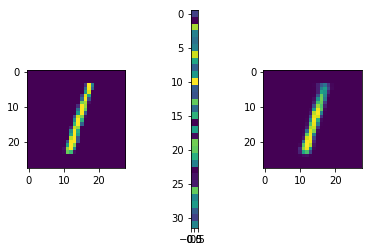

In [0]:
def plot_imgs(index=0):
  f = plt.figure()
  f.add_subplot(1,3, 1)
  plt.imshow(x_test[index].reshape(28, 28))
  f.add_subplot(1,3, 2)
  plt.imshow(encoded_images[index].reshape(-1, 1))
  f.add_subplot(1,3, 3)
  plt.imshow(predicted[index].reshape(28, 28))
  plt.show(block=True)
  
plot_imgs(2)

# Let's use Convolutional Neural Nets to get better results

In [0]:
from keras.layers import Dense, Input, UpSampling2D, Conv2D

Getting data

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [0]:
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

In [0]:
x_train = x_train.reshape((60000, 28, 28, 1))
x_test = x_test.reshape((10000, 28, 28, 1))

In [0]:
img_height, img_width, _ = x_train[1].shape

In [0]:
def CNN_AE():
    input_img = Input(shape=(img_width, img_height, 1))
    
    # Encoding network
    x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(input_img)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(x)
    encoded = Conv2D(32, (2, 2), activation='relu', padding="same", strides=2)(x)

    # Decoding network
    x = Conv2D(32, (2, 2), activation='relu', padding="same")(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    encoder = Model(input_img, encoded)
    
    return Model(input_img, decoded), encoder

In [0]:
model_cnn, encoder = CNN_AE()
model_cnn.compile(optimizer='adadelta', loss='binary_crossentropy')

In [0]:
cnn_hist = model_cnn.fit(x_train, x_train, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 20s 339us/step - loss: 0.0899 - val_loss: 0.0844


In [0]:
reconstruct = model_cnn.predict(x_test)

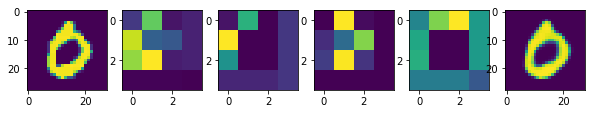

In [0]:
def plot_imgs_for_cnn(index=0):
  f = plt.figure(figsize=(10, 10))
  f.add_subplot(1,6, 1)
  plt.imshow(x_test[index].reshape(28, 28))
   
  
  f.add_subplot(1,6, 2)
  plt.imshow(encoded_images[index][:, :, 0])
  f.add_subplot(1,6, 3)
  plt.imshow(encoded_images[index][:, :, 1])
  f.add_subplot(1,6, 4)
  plt.imshow(encoded_images[index][:, :, 2])
  f.add_subplot(1,6, 5)
  plt.imshow(encoded_images[index][:, :, 3])
  
  
  f.add_subplot(1,6, 6)
  plt.imshow(reconstruct[index].reshape(28,28))
  
  plt.show(block=True)
  
plot_imgs_for_cnn(3)

# **Denoising example**

In [0]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [155]:
cnn_hist = model_cnn.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 20s 333us/step - loss: 0.1180 - val_loss: 0.1100


In [0]:
reconstruct = model_cnn.predict(x_test_noisy)
encoded_images= encoder.predict(x_test_noisy)

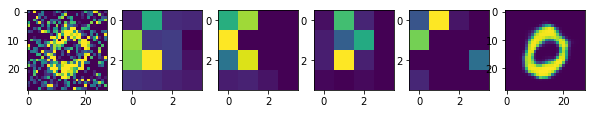

In [163]:
def plot_imgs_for_cnn_noisy(index=0):
  f = plt.figure(figsize=(10, 10))
  f.add_subplot(1,6, 1)
  plt.imshow(x_test_noisy[index].reshape(28, 28))
   
  
  f.add_subplot(1,6, 2)
  plt.imshow(encoded_images[index][:, :, 0])
  f.add_subplot(1,6, 3)
  plt.imshow(encoded_images[index][:, :, 1])
  f.add_subplot(1,6, 4)
  plt.imshow(encoded_images[index][:, :, 2])
  f.add_subplot(1,6, 5)
  plt.imshow(encoded_images[index][:, :, 3])
  
  
  f.add_subplot(1,6, 6)
  plt.imshow(reconstruct[index].reshape(28,28))
  
  plt.show(block=True)
  
plot_imgs_for_cnn_noisy(3)